In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
from gensim.parsing.preprocessing import STOPWORDS
import spacy
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error

from torch.utils.data import Dataset, DataLoader
import torch
from torch import nn
import torch.nn.functional as F

from warnings import filterwarnings
filterwarnings('ignore')

## Load Data

In [2]:
df = pd.read_csv('Feedback.csv')
df = df[['Feedback', 'Rating']]
df['Rating'] = df['Rating'].astype(int)
df['Rating'] = df['Rating'] - 1
df.shape

(17249, 2)

In [3]:
df.head()

,Feedback,Rating
0,Я являюсь пользователем Пилотов уже больше 10 ...,4
1,хорошая. почти два года. корпус внушающий дове...,4
2,Отличная кофемолка во всех отношениях: качеств...,4
3,"Плюсы: компактная, удобна в обращении, не кокс...",4
4,Тоже сломалась - похоже сгорел мотор.,1


## Preprocessing

In [4]:
# words count without punctuation
from string import punctuation
all_reviews = []
reviews = df['Feedback'].values

for text in reviews:
  text = text.lower()
  text = "".join([ch for ch in text if ch not in punctuation])
  all_reviews.append(text)
all_text = " ".join(all_reviews)
all_words = all_text.split()

In [5]:
# Calculate words frquency
from collections import Counter 

count_words = Counter(all_words)
total_words=len(all_words)
sorted_words=count_words.most_common(total_words)
print(f"Top ten occuring words : {sorted_words[:10]}")

Top ten occuring words : [('и', 24967), ('не', 23165), ('в', 19261), ('на', 14310), ('что', 8446), ('с', 8279), ('очень', 8211), ('но', 6814), ('для', 5322), ('а', 5237)]


In [6]:
# Stopwords
words_frequency = np.array([i[1] for i in sorted_words])
lower_bound = 2
upper_bound = np.quantile(words_frequency, 0.99)
my_stop_words = [i[0] for i in sorted_words if i[1] <= lower_bound or i[1] >= upper_bound]

# stopwords = STOPWORDS.union(set(my_stop_words))
stopwords = STOPWORDS.union(set(punctuation))

In [7]:
# lower
df['Feedback'] = df['Feedback'].str.lower()
# remove punctuation
df['Feedback'] = df['Feedback'].apply(lambda x: "".join([i for i in x if i not in punctuation]))
# remove stopwords
df['Feedback'] = df['Feedback'].apply(lambda x: [i for i in x.split() if i not in stopwords and len(i) > 2])

In [8]:
df.head()

,Feedback,Rating
0,"[являюсь, пользователем, пилотов, уже, больше,...",4
1,"[хорошая, почти, два, года, корпус, внушающий,...",4
2,"[отличная, кофемолка, всех, отношениях, качест...",4
3,"[плюсы, компактная, удобна, обращении, коксует...",4
4,"[тоже, сломалась, похоже, сгорел, мотор]",1


## Prepare data for training

In [9]:
#creating vocabulary
vocab2index = {"":0, "UNK":1}
counts = [i for i in sorted_words if i[0] not in stopwords]
words = ["", "UNK"]
for word in counts:
    vocab2index[word[0]] = len(words)
    words.append(word)

In [10]:
tok = spacy.load('ru2_combined_400ks_96')
def tokenize(text):
    return [token.text for token in tok.tokenizer(text)]

In [11]:
def encode_sentence(text, vocab2index, N=30):
    tokenized = tokenize(text)
    encoded = np.zeros(N, dtype=int)
    enc1 = np.array([vocab2index.get(word, vocab2index["UNK"]) for word in tokenized])
    length = min(N, len(enc1))
    encoded[:length] = enc1[:length]
    return encoded, length

In [12]:
# tokenize text
df['Feedback'] = df['Feedback'].apply(lambda x: ' '.join(x))
df['Feedback'] = df['Feedback'].apply(lambda x: np.array(encode_sentence(x, vocab2index )))

In [13]:
# drop for packed sequence
df = df.loc[df['Feedback'].apply(lambda x: x[1]) != 0]

In [14]:
# calculate baseline metrics
baseline_mae = mean_absolute_error(np.full((df.shape[0]), int(df['Rating'].mean())), df['Rating'])

In [15]:
df.head()

,Feedback,Rating
0,"[[3545, 7980, 28669, 27, 72, 98, 43, 3425, 197...",4
1,"[[117, 136, 139, 38, 294, 28671, 4811, 104, 11...",4
2,"[[115, 1244, 177, 6814, 64, 128, 884, 303, 529...",4
3,"[[275, 946, 884, 1051, 28673, 256, 127, 4175, ...",4
4,"[[66, 474, 1655, 933, 1599, 0, 0, 0, 0, 0, 0, ...",1


## Create Pytorch Dataset

In [16]:
# create X, y
X = np.array(df['Feedback'])
y = np.array(df['Rating'])

X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.2)

In [17]:
class CustomDataset(Dataset):
    def __init__(self, X, Y):
        self.X = X
        self.y = Y
        
    def __len__(self):
        return len(self.y)
    
    def __getitem__(self, idx):
        return torch.from_numpy(self.X[idx][0]).long(), self.y[idx].long(), self.X[idx][1]

In [18]:
# create custom dataset
train_ds = CustomDataset(X_train, torch.Tensor(y_train))
valid_ds = CustomDataset(X_valid, torch.Tensor(y_valid))

In [19]:
def train_model(model, epochs=10, lr=0.001):
    # metrics
    train_loss = []
    test_loss = []
    # train loop
    parameters = filter(lambda p: p.requires_grad, model.parameters())
    optimizer = torch.optim.Adam(parameters, lr=lr)
    for i in range(epochs):
        model.train()
        sum_loss = 0.0
        total = 0
        for x, y, l in train_dl:
            y_pred = model(x, l)
            optimizer.zero_grad()
            loss = F.cross_entropy(y_pred, y)
            loss.backward()
            optimizer.step()
            sum_loss += loss.item()*y.shape[0]
            total += y.shape[0]
        val_loss, val_acc, val_mae = validation_metrics(model, val_dl)
        print("train loss %.3f, val loss %.3f, val accuracy %.3f, and val MAE %.3f" % (sum_loss/total, val_loss, val_acc, val_mae/baseline_mae))
        train_loss.append(sum_loss/total)
        test_loss.append(val_loss)
    return train_loss, test_loss


def validation_metrics(model, valid_dl):
    model.eval()
    correct = 0
    total = 0
    sum_loss = 0.0
    sum_mae = 0.0
    for x, y, l in valid_dl:
        y_hat = model(x, l)
        loss = F.cross_entropy(y_hat, y)
        pred = torch.max(y_hat, 1)[1]
        correct += (pred == y).float().sum()
        total += y.shape[0]
        sum_loss += loss.item()*y.shape[0]
        sum_mae += mean_absolute_error(pred, y.unsqueeze(-1))*y.shape[0]
    return sum_loss/total, correct/total, sum_mae/total

In [20]:
def print_losses(train_loss, test_loss):
    plt.figure(figsize=(15,6))
    plt.plot(train_loss)
    plt.plot(test_loss)
    plt.legend(['Train', 'Test'])
    plt.show()

In [21]:
# training parameters
batch_size = 256
vocab_size = len(words)
# create dataloader
train_dl = DataLoader(train_ds, batch_size=batch_size, shuffle=True)
val_dl = DataLoader(valid_ds, batch_size=batch_size)

## MaxPool Example

In [22]:
class PoolingModel(torch.nn.Module):
    def __init__(self, vocab_size, embedding_dim):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, embedding_dim, padding_idx=0)
        self.linear = nn.Linear(50, 5)
        
    def forward(self, x, l):
        x = self.embedding(x) # [128, 30, 50]
        x = x.mean(dim=1) # [128, 50]
        output = self.linear(x) # [128/batch_size, 5]
        return output

In [23]:
model_pooling = PoolingModel(vocab_size, 50)

In [24]:
train_loss, test_loss = train_model(model_pooling, epochs=30, lr=0.001)

train loss 1.591, val loss 1.529, val accuracy 0.415, and val MAE 1.498
train loss 1.450, val loss 1.373, val accuracy 0.581, and val MAE 0.875
train loss 1.295, val loss 1.247, val accuracy 0.599, and val MAE 0.803
train loss 1.194, val loss 1.187, val accuracy 0.603, and val MAE 0.788
train loss 1.138, val loss 1.153, val accuracy 0.605, and val MAE 0.779
train loss 1.093, val loss 1.125, val accuracy 0.606, and val MAE 0.769
train loss 1.051, val loss 1.100, val accuracy 0.612, and val MAE 0.753
train loss 1.009, val loss 1.077, val accuracy 0.620, and val MAE 0.724
train loss 0.967, val loss 1.057, val accuracy 0.625, and val MAE 0.695
train loss 0.926, val loss 1.039, val accuracy 0.628, and val MAE 0.678
train loss 0.886, val loss 1.023, val accuracy 0.631, and val MAE 0.663
train loss 0.848, val loss 1.010, val accuracy 0.631, and val MAE 0.656
train loss 0.811, val loss 0.999, val accuracy 0.628, and val MAE 0.647
train loss 0.775, val loss 0.991, val accuracy 0.634, and val MA

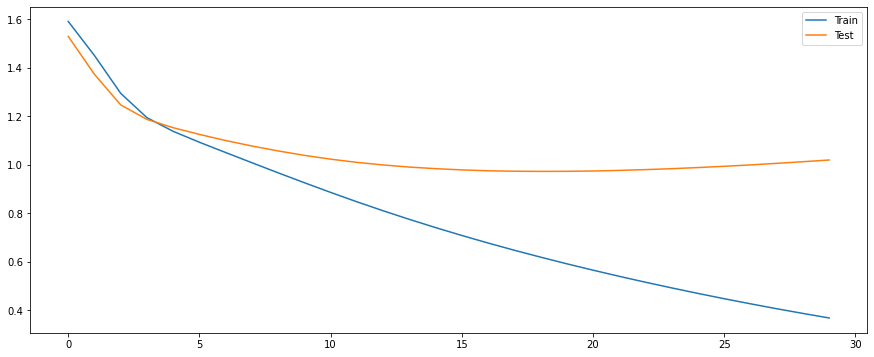

In [25]:
print_losses(train_loss, test_loss)

## Fixed len LSTM

In [26]:
class LSTM_fixed_len(torch.nn.Module) :
    def __init__(self, vocab_size, embedding_dim, hidden_dim):
        super().__init__()
        self.embeddings = nn.Embedding(vocab_size, embedding_dim, padding_idx=0)
        self.lstm = nn.LSTM(embedding_dim, hidden_dim, batch_first=True)
        self.linear1 = nn.Linear(hidden_dim*3, 32)
        self.linear2 = nn.Linear(32, 5)
        self.dropout = nn.Dropout(0.3)
        
        self.relu = nn.ReLU(inplace=True)
        self.batchnorm = nn.BatchNorm1d(32)
        
    def forward(self, x, l):
        x = self.embeddings(x)
        x = self.dropout(x)
        lstm_out, (ht, ct) = self.lstm(x)
        x = self.linear1(torch.cat((lstm_out[torch.arange(lstm_out.shape[0]), l-1], ht[-1], ct[-1]), axis=1))
        x = self.batchnorm(x)
        x = self.relu(x)
        x = self.linear2(x)
        return x

In [27]:
model_fixed = LSTM_fixed_len(vocab_size, 50, 50)

In [28]:
train_loss, test_loss = train_model(model_fixed, epochs=30, lr=0.001)

train loss 1.550, val loss 1.336, val accuracy 0.593, and val MAE 0.812
train loss 1.256, val loss 1.194, val accuracy 0.603, and val MAE 0.797
train loss 1.190, val loss 1.176, val accuracy 0.603, and val MAE 0.797
train loss 1.164, val loss 1.160, val accuracy 0.603, and val MAE 0.796
train loss 1.138, val loss 1.145, val accuracy 0.602, and val MAE 0.797
train loss 1.112, val loss 1.125, val accuracy 0.600, and val MAE 0.796
train loss 1.073, val loss 1.107, val accuracy 0.602, and val MAE 0.778
train loss 1.024, val loss 1.065, val accuracy 0.608, and val MAE 0.737
train loss 0.985, val loss 1.047, val accuracy 0.610, and val MAE 0.741
train loss 0.946, val loss 1.040, val accuracy 0.607, and val MAE 0.716
train loss 0.909, val loss 1.041, val accuracy 0.607, and val MAE 0.688
train loss 0.880, val loss 1.043, val accuracy 0.610, and val MAE 0.732
train loss 0.845, val loss 1.046, val accuracy 0.617, and val MAE 0.668
train loss 0.814, val loss 1.065, val accuracy 0.611, and val MA

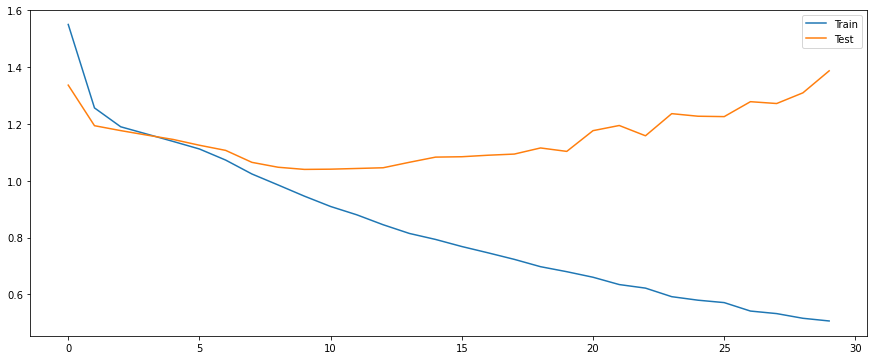

In [29]:
print_losses(train_loss, test_loss)

## Variable len LSTM

In [30]:
class LSTM_variable_input(torch.nn.Module) :
    def __init__(self, vocab_size, embedding_dim, hidden_dim) :
        super().__init__()
        self.hidden_dim = hidden_dim
        self.dropout = nn.Dropout(0.3)
        self.embeddings = nn.Embedding(vocab_size, embedding_dim, padding_idx=0)
        self.lstm = nn.LSTM(embedding_dim, hidden_dim, batch_first=True)
        self.linear1 = nn.Linear(hidden_dim*2, 32)
        self.linear2 = nn.Linear(32, 5)
        
        self.relu = nn.ReLU(inplace=True)
        self.batchnorm = nn.BatchNorm1d(32)
        
    def forward(self, x, s):
        x = self.embeddings(x)
        x = self.dropout(x)
        x_pack = nn.utils.rnn.pack_padded_sequence(x, s, batch_first=True, enforce_sorted=False)
        out_pack, (ht, ct) = self.lstm(x_pack)
        x = self.linear1(torch.cat((ht[-1], ct[-1]), axis=1))
        x = self.batchnorm(x)
        x = self.relu(x)
        x = self.linear2(x)
        return x

In [31]:
model = LSTM_variable_input(vocab_size, 50, 50)

In [32]:
train_loss, test_loss = train_model(model, epochs=30, lr=0.001)

train loss 1.562, val loss 1.341, val accuracy 0.566, and val MAE 0.836
train loss 1.249, val loss 1.201, val accuracy 0.602, and val MAE 0.796
train loss 1.179, val loss 1.176, val accuracy 0.602, and val MAE 0.797
train loss 1.150, val loss 1.165, val accuracy 0.601, and val MAE 0.797
train loss 1.120, val loss 1.129, val accuracy 0.601, and val MAE 0.792
train loss 1.075, val loss 1.105, val accuracy 0.598, and val MAE 0.810
train loss 1.035, val loss 1.095, val accuracy 0.592, and val MAE 0.832
train loss 1.000, val loss 1.087, val accuracy 0.589, and val MAE 0.838
train loss 0.960, val loss 1.087, val accuracy 0.607, and val MAE 0.736
train loss 0.929, val loss 1.096, val accuracy 0.591, and val MAE 0.804
train loss 0.901, val loss 1.073, val accuracy 0.607, and val MAE 0.740
train loss 0.874, val loss 1.127, val accuracy 0.612, and val MAE 0.705
train loss 0.839, val loss 1.208, val accuracy 0.613, and val MAE 0.707
train loss 0.822, val loss 1.197, val accuracy 0.617, and val MA

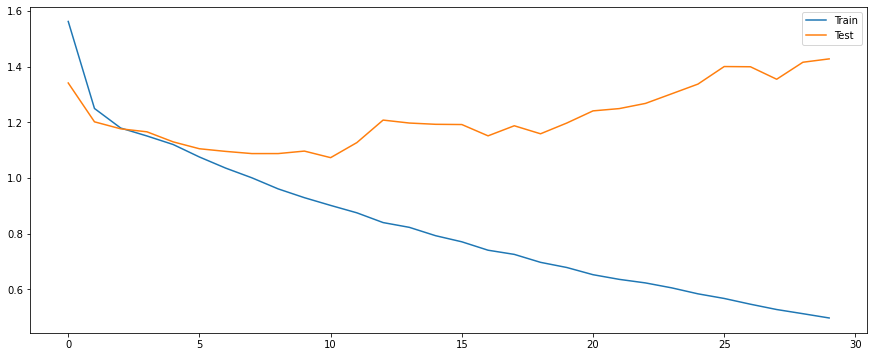

In [33]:
print_losses(train_loss, test_loss)

## FastText Embeddings

In [34]:
from torchnlp.word_to_vector import FastText

In [35]:
word_vecs = FastText(language='ru')

In [36]:
def get_emb_matrix(pretrained, word_counts, emb_size = 50):
    vocab_size = len(word_counts) + 2
    vocab_to_idx = {}
    vocab = ["", "UNK"]
    W = np.zeros((vocab_size, emb_size), dtype="float32")
    W[0] = np.zeros(emb_size, dtype='float32') # adding a vector for padding
    W[1] = np.random.uniform(-0.25, 0.25, emb_size) # adding a vector for unknown words 
    vocab_to_idx["UNK"] = 1
    i = 2
    for word in word_counts:
        if word[0] in word_vecs:
            W[i] = word_vecs[word[0]][:emb_size]
        else:
            W[i] = np.random.uniform(-0.25,0.25, emb_size)
        vocab_to_idx[word] = i
        vocab.append(word)
        i += 1   
    return W, np.array(vocab), vocab_to_idx

In [37]:
pretrained_weights, vocab, vocab2index = get_emb_matrix(word_vecs, counts)

In [38]:
class LSTM_fasttext_vecs(torch.nn.Module) :
    def __init__(self, vocab_size, embedding_dim, hidden_dim, fasttext_weights) :
        super().__init__()
        self.embeddings = nn.Embedding(vocab_size, embedding_dim, padding_idx=0)
        self.embeddings.weight.data.copy_(torch.from_numpy(fasttext_weights))
        self.embeddings.weight.requires_grad = False ## freeze embeddings
        self.lstm = nn.LSTM(embedding_dim, hidden_dim, batch_first=True)
        self.linear1 = nn.Linear(hidden_dim*3, 32)
        self.linear2 = nn.Linear(32, 5)
        self.dropout = nn.Dropout(0.3)
        
        self.relu = nn.ReLU(inplace=True)
        self.batchnorm = nn.BatchNorm1d(32)
        
    def forward(self, x, l):
        x = self.embeddings(x)
        x = self.dropout(x)
        lstm_out, (ht, ct) = self.lstm(x)
        x = self.linear1(torch.cat((lstm_out[torch.arange(lstm_out.shape[0]), l-1], ht[-1], ct[-1]), axis=1))
        x = self.batchnorm(x)
        x = self.relu(x)
        x = self.linear2(x)
        return x

In [39]:
model = LSTM_fasttext_vecs(vocab_size, 50, 50, pretrained_weights)

In [40]:
train_loss, test_loss = train_model(model, epochs=30, lr=0.001)

train loss 1.323, val loss 1.223, val accuracy 0.603, and val MAE 0.797
train loss 1.159, val loss 1.098, val accuracy 0.611, and val MAE 0.756
train loss 1.110, val loss 1.074, val accuracy 0.611, and val MAE 0.751
train loss 1.096, val loss 1.062, val accuracy 0.622, and val MAE 0.708
train loss 1.087, val loss 1.054, val accuracy 0.620, and val MAE 0.720
train loss 1.078, val loss 1.063, val accuracy 0.619, and val MAE 0.719
train loss 1.071, val loss 1.061, val accuracy 0.619, and val MAE 0.723
train loss 1.059, val loss 1.028, val accuracy 0.619, and val MAE 0.705
train loss 1.050, val loss 1.022, val accuracy 0.623, and val MAE 0.693
train loss 1.043, val loss 1.031, val accuracy 0.621, and val MAE 0.695
train loss 1.029, val loss 1.032, val accuracy 0.617, and val MAE 0.681
train loss 1.020, val loss 1.004, val accuracy 0.627, and val MAE 0.679
train loss 1.015, val loss 1.092, val accuracy 0.585, and val MAE 0.693
train loss 0.999, val loss 1.010, val accuracy 0.622, and val MA

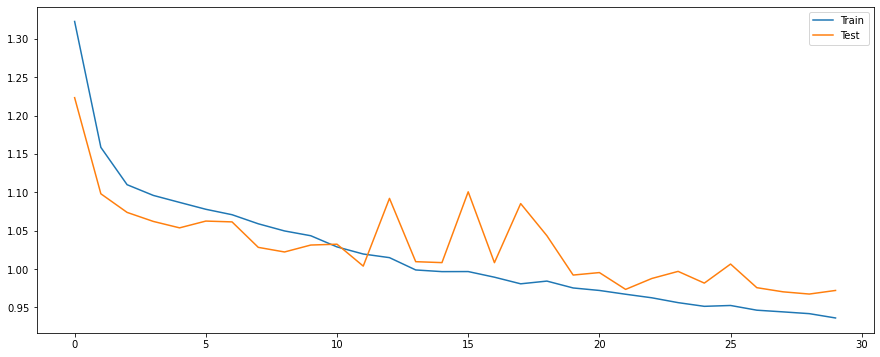

In [41]:
print_losses(train_loss, test_loss)

## Try Different optimizers

In [42]:
def train_model(model, optimizer_type, epochs=10, lr=0.001):
    # metrics
    train_loss = []
    test_loss = []
    # train loop
    parameters = filter(lambda p: p.requires_grad, model.parameters())
    if optimizer_type == 'Adam':
        optimizer = torch.optim.Adam(parameters, lr=lr)
    elif optimizer_type == 'RMSprop':
        optimizer = torch.optim.RMSprop(parameters, lr=lr)
    elif optimizer_type == 'Adagrad':
        optimizer = torch.optim.Adagrad(parameters, lr=lr)
    for i in range(epochs):
        model.train()
        sum_loss = 0.0
        total = 0
        for x, y, l in train_dl:
            y_pred = model(x, l)
            optimizer.zero_grad()
            loss = F.cross_entropy(y_pred, y)
            loss.backward()
            optimizer.step()
            sum_loss += loss.item()*y.shape[0]
            total += y.shape[0]
        val_loss, val_acc, val_mae = validation_metrics(model, val_dl)
        if i % 5 == 1:
            print("train loss %.3f, val loss %.3f, val accuracy %.3f, and val MAE %.3f" % (sum_loss/total, val_loss, val_acc, val_mae/baseline_mae))
        train_loss.append(sum_loss/total)
        test_loss.append(val_loss)
    return train_loss, test_loss

train loss 1.203, val loss 1.178, val accuracy 0.603, and val MAE 0.797
train loss 1.101, val loss 1.140, val accuracy 0.603, and val MAE 0.789
train loss 0.917, val loss 1.096, val accuracy 0.615, and val MAE 0.693
train loss 0.758, val loss 1.123, val accuracy 0.619, and val MAE 0.637
train loss 0.648, val loss 1.178, val accuracy 0.611, and val MAE 0.638
train loss 0.541, val loss 1.286, val accuracy 0.603, and val MAE 0.615


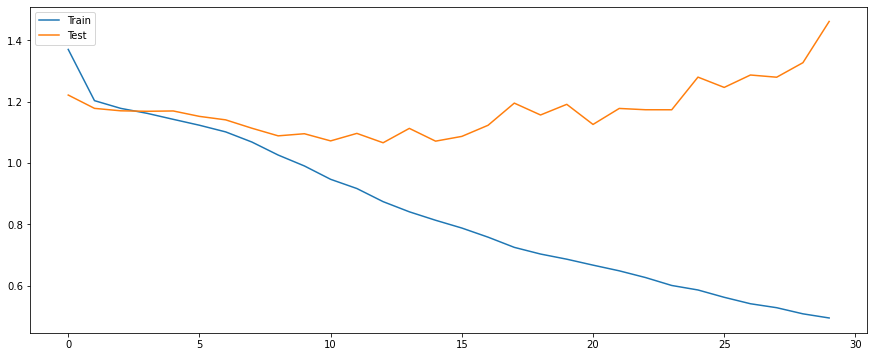

In [43]:
model = LSTM_fixed_len(vocab_size, 50, 50)
train_loss, test_loss = train_model(model, optimizer_type='Adam', epochs=30, lr=0.001)
print_losses(train_loss, test_loss)

train loss 1.175, val loss 1.155, val accuracy 0.602, and val MAE 0.797
train loss 0.993, val loss 1.042, val accuracy 0.601, and val MAE 0.789
train loss 0.874, val loss 1.031, val accuracy 0.615, and val MAE 0.656
train loss 0.774, val loss 1.053, val accuracy 0.594, and val MAE 0.668
train loss 0.691, val loss 1.115, val accuracy 0.604, and val MAE 0.617
train loss 0.624, val loss 1.170, val accuracy 0.594, and val MAE 0.635


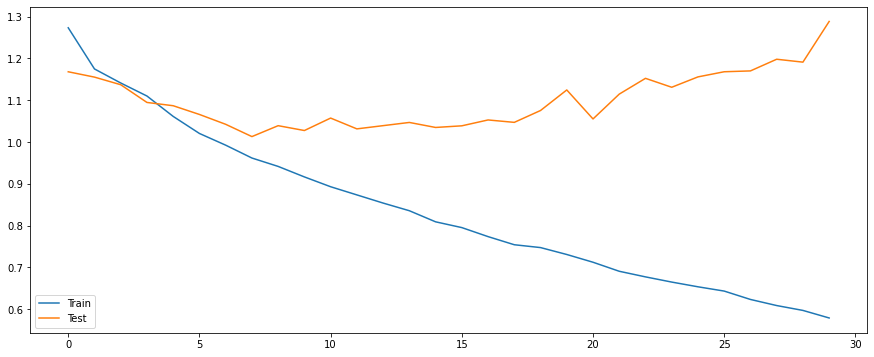

In [44]:
model = LSTM_fixed_len(vocab_size, 50, 50)
train_loss, test_loss = train_model(model, optimizer_type='RMSprop', epochs=30, lr=0.001)
print_losses(train_loss, test_loss)

train loss 1.587, val loss 1.564, val accuracy 0.279, and val MAE 1.182
train loss 1.402, val loss 1.411, val accuracy 0.522, and val MAE 0.854
train loss 1.317, val loss 1.329, val accuracy 0.574, and val MAE 0.808
train loss 1.268, val loss 1.286, val accuracy 0.589, and val MAE 0.800
train loss 1.240, val loss 1.255, val accuracy 0.595, and val MAE 0.798
train loss 1.219, val loss 1.237, val accuracy 0.599, and val MAE 0.798


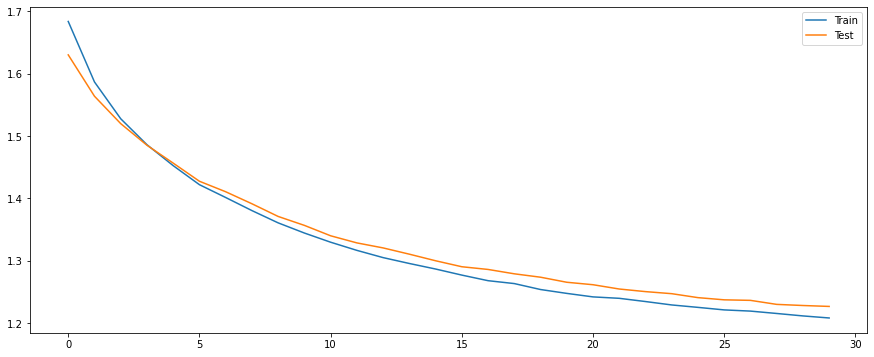

In [45]:
model = LSTM_fixed_len(vocab_size, 50, 50)
train_loss, test_loss = train_model(model, optimizer_type='Adagrad', epochs=30, lr=0.001)
print_losses(train_loss, test_loss)